# CE-40959: Advanced Machine Learning
## HW5 - Continual Learning (90 points)

#### Name: Sepehr Ghobadi
#### Student No: 400211008

In this notebook, you are going to see the `catastrophic forgetting` phenomenon in continual learning scenarios and then alleviate this problem by implementing [Gradient Episodic Memory(GEM)](https://arxiv.org/abs/1706.08840) on the `MNIST` dataset.


Please write your code in specified sections and do not change anything else. If you have a question regarding this homework, please ask it on the Quera.

Also, it is recommended to use Google Colab to do this homework. You can connect to your drive using the code below:

In [5]:
from google.colab import drive
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/MyDrive/AdvancedML/GEM"
%cd $DRIVE_PATH

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AdvancedML/GEM


## Import Required libraries

In [6]:
!pip install quadprog

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 121 kB 7.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for quadprog: filename=quadprog-0.1.11-cp37-cp37m-linux_x86_64.whl size=290742 sha256=582a8c798aaebd4afe919ada47b133eb7a902252c60be86137ff4b820b1a6b0b
  Stored in directory: /root/.cache/pip/wheels/4a/4e/d7/41034ea11aeef1266df3cae546116cb6094e955c41ae3e2589
Successfully built quadprog


In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import random
import torch.nn as nn
import math
import quadprog
import pickle
from tqdm import tqdm

import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils.data as data

## Learning parameters

In [8]:
num_classes = 10
class_per_task = 2
number_of_data_per_class = 3000
num_tasks = int(num_classes // class_per_task)
batch_size = 10 #10
memory_size_per_task = 10 #10

## Prepare dataset (5 points)

To compare different benchmarks fairly, define all of your dataloaders for each task and save them in an array.

In [9]:
def get_all_dataloaders(num_classes, class_per_task, number_of_data_per_class, num_tasks, batch_size):
    #################################################################################
    #                  COMPLETE THE FOLLOWING SECTION (2.5 points)                   #
    #################################################################################
    # complete the function to get all dataloaders for all tasks
    mnist_train = torchvision.datasets.MNIST(DRIVE_PATH+'/mnist', train=True, download=True)
    if num_tasks*class_per_task != num_classes:
        print("invalid mnist split!")
        raise NotImplemented
    classes, is_chosen = range(num_classes), [False]*num_classes
    dataloaders = []
    tasks = []

    #random tasks

    for t in range(num_tasks):
        task_classes = np.random.choice([c for c in classes if not is_chosen[c]], size=class_per_task, replace=False)
        tasks.append(task_classes)
        for c in task_classes:
            is_chosen[c]=True
        # x_tr = torch.cat([mnist_train.train_data[mnist_train.train_labels==c][:number_of_data_per_class] for c in task_classes])
        # y_tr = torch.cat([mnist_train.train_labels[mnist_train.train_labels==c][:number_of_data_per_class] for c in task_classes])

        x_tr, y_tr = [], []
        for c in task_classes:
            x_c, y_c = mnist_train.data[mnist_train.targets==c], mnist_train.targets[mnist_train.targets==c]
            indices = np.random.choice(range(len(x_c)), number_of_data_per_class, replace=False)
            x_tr.append(x_c[indices,:,:])
            y_tr.append(y_c[indices])
        x_tr, y_tr = torch.cat(x_tr), torch.cat(y_tr)
        
        dataloaders.append( data.DataLoader(data.TensorDataset(x_tr, y_tr), batch_size=batch_size, shuffle=True) )

    return tasks, dataloaders

    #################################################################################


def get_testloader(tasks, batch_size):
    #################################################################################
    #                  COMPLETE THE FOLLOWING SECTION (2.5 points)                   #
    #################################################################################
    # complete the function to get MNIST test dataloader
    mnist_test = torchvision.datasets.MNIST(DRIVE_PATH+'/mnist', train=False, download=True)
    dataloaders = []
    for task_classes in tasks:
        x_tr = torch.cat([mnist_test.data[mnist_test.targets==c] for c in task_classes])
        y_tr = torch.cat([mnist_test.targets[mnist_test.targets==c] for c in task_classes])
        dataloaders.append( data.DataLoader(data.TensorDataset(x_tr, y_tr), batch_size=batch_size, shuffle=True) )
    return dataloaders
    #################################################################################

In [10]:
tasks, train_dataloaders = get_all_dataloaders(num_classes, class_per_task, number_of_data_per_class, num_tasks, batch_size)
test_dataloaders = get_testloader(tasks, batch_size)
with open(DRIVE_PATH+"/dataloaders.pickle", 'wb') as f:
    pickle.dump((tasks, train_dataloaders, test_dataloaders), f)

In [11]:
with open(DRIVE_PATH+"/dataloaders.pickle", 'rb') as f:
    (tasks, train_dataloaders, test_dataloaders) = pickle.load(f)

## Network (5 points)

In [12]:
# define a 3 layer fc with relu activation functions between layers
# your fc layers dimensions are as follows:
# 784, 150, 150, 10


#################################################################################
#                  COMPLETE THE FOLLOWING SECTION (5 points)                   #
#################################################################################
# define above mentioned model and needed variables

class FC(torch.nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 150),
            nn.ReLU(),
            nn.Linear(150, 150),
            nn.ReLU(),
            nn.Linear(150, 10)
        )

    def forward(self, x):
        return self.layers(x)

#################################################################################

## Naive Learning (20 points)

In this section, you will learn a network in its natural state, without considering any strategy for learning it continually. You will see that learning data in a such fashion causes a phenomenon called catastrophic forgetting.

As `GEM` is a task-incremental method, like the paper, evaluate your trained model performance for each task and then report the average accuracy of tasks. In addition to Accuracy metric, report the `backward transfer` and `forward transfer` metric based on the defination in the paper.

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FC()
criterion = torch.nn.CrossEntropyLoss()
lr = 0.001
optimizer = optim.SGD(model.parameters(), lr=lr)



#################################################################################
#                  COMPLETE THE FOLLOWING SECTION (20 points)                   #
#################################################################################
# complete code for sequentially training and then
# evaluate your model with test data

def fwd_pass(model, optimizer, dataloader, is_eval):
    accs = []
    if not is_eval:
        print("Train:")
        dataloader = tqdm(dataloader)
    for idx, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        logits = model(x.float())
        loss = criterion(logits, y)
        if not is_eval:
            loss.backward()
            optimizer.step()

        if idx%100==0:
            torch.save(model.state_dict(), DRIVE_PATH+'/model.pt')

        y_pred = torch.argmax(logits, dim=1)
        accs.append( torch.sum(y_pred == y)/x.size(0) )
    return np.mean(accs)

def get_stats(b, R):
    num_tasks = R.shape[0]
    acc = np.mean(R[-1][:])
    bwt = np.mean([R[-1][i]-R[i][i] for i in range(num_tasks-1)])
    fwt = np.mean([R[i-1][i]-b[i] for i in range(1,num_tasks)])
    return acc, bwt, fwt

with torch.no_grad():
    b = np.array([fwd_pass(model, optimizer, dataloader, is_eval=True) for dataloader in test_dataloaders])
R = np.array([[None]*num_tasks for _ in range(num_tasks)])

for i in range(num_tasks):
    print(f"Task {i+1} Classes: {tasks[i]}")
    _ = fwd_pass(model, optimizer, train_dataloaders[i], is_eval=False)
    with torch.no_grad():
        for j in range(num_tasks):
            R[i][j] = fwd_pass(model, optimizer, test_dataloaders[j], is_eval=True)
            print(f"Accuracy of task {j+1} after training on task {i+1}:  {R[i][j]}")

with open(DRIVE_PATH+"/results_single.pickle", 'wb') as f:
    pickle.dump((b, R), f)


acc, bwt, fwt = get_stats(b, R)
print(f"ACC: {acc} \n BWT: {bwt} \n FWT: {fwt}")

#################################################################################

Task 1 Classes: [5 8]
Train:


100%|██████████| 600/600 [00:01<00:00, 567.37it/s]


Accuracy of task 1 after training on task 1:  0.9807486534118652
Accuracy of task 2 after training on task 1:  0.0
Accuracy of task 3 after training on task 1:  0.0
Accuracy of task 4 after training on task 1:  0.0
Accuracy of task 5 after training on task 1:  0.0
Task 2 Classes: [1 7]
Train:


100%|██████████| 600/600 [00:00<00:00, 765.66it/s]


Accuracy of task 1 after training on task 2:  0.025133688002824783
Accuracy of task 2 after training on task 2:  0.9898616671562195
Accuracy of task 3 after training on task 2:  0.0
Accuracy of task 4 after training on task 2:  0.0
Accuracy of task 5 after training on task 2:  0.0005025125574320555
Task 3 Classes: [4 9]
Train:


100%|██████████| 600/600 [00:00<00:00, 727.41it/s]


Accuracy of task 1 after training on task 3:  0.0032085562124848366
Accuracy of task 2 after training on task 3:  0.1092165932059288
Accuracy of task 3 after training on task 3:  0.9689999222755432
Accuracy of task 4 after training on task 3:  0.002010050229728222
Accuracy of task 5 after training on task 3:  0.0005025125574320555
Task 4 Classes: [3 0]
Train:


100%|██████████| 600/600 [00:00<00:00, 770.89it/s]


Accuracy of task 1 after training on task 4:  0.0010695187374949455
Accuracy of task 2 after training on task 4:  0.0013824885245412588
Accuracy of task 3 after training on task 4:  0.027499999850988388
Accuracy of task 4 after training on task 4:  0.9929648637771606
Accuracy of task 5 after training on task 4:  0.0
Task 5 Classes: [6 2]
Train:


100%|██████████| 600/600 [00:00<00:00, 737.07it/s]


Accuracy of task 1 after training on task 5:  0.0010695187374949455
Accuracy of task 2 after training on task 5:  0.0013824885245412588
Accuracy of task 3 after training on task 5:  0.0020000000949949026
Accuracy of task 4 after training on task 5:  0.0663316547870636
Accuracy of task 5 after training on task 5:  0.9844220876693726
ACC: 0.2110411375761032 
 BWT: -0.9654479026794434 
 FWT: -0.11450332403182983


## Continually Learning using GEM (50 points)

In this section, you will complete the codes for the GEM method using the beforementioned parameters. Read the procedure explained in the paper. We pre-defined some functions for you. Complete them and use them in training.

In [14]:
# define your main class for continually learning with GEM
# define all needed variables and functions, all inside this class

class GEM(torch.nn.Module):
    def __init__(self, memory_size, lr):
        super(GEM, self).__init__()   
        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (5 points)                   #
        #################################################################################
        # define above mentioned model and needed variables
        self.model = FC()
        self.optimizer = optim.SGD(self.model.parameters(), lr)
        self.criterion = torch.nn.CrossEntropyLoss()
        
        self.memory_size = memory_size
        self.memory_datas = torch.FloatTensor(1, memory_size ,28, 28)
        self.memory_targets = torch.LongTensor(1, self.memory_size)
        self.memory_heads = [0]

        self.grad_dims = []
        for param in self.model.parameters():
            self.grad_dims.append(param.data.numel())
        self.grads = torch.FloatTensor(1, sum(self.grad_dims))
        
        self.num_tasks_learned = 0
        #self.grads = torch.Tensor(sum(self.grad_dims), num_tasks)
        # TODO move grads to device
        
        #################################################################################

    def calculate_past_classes_gradients(self):
        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (10 points)                   #
        #################################################################################
        
        for t_idx in range(self.num_tasks_learned):
            task_data, task_targets = self.memory_datas[t_idx], self.memory_targets[t_idx]
            self.model.zero_grad()
            logits = self.model(task_data)
            loss = self.criterion(logits, task_targets)
            loss.backward()

            self.grads[t_idx, :].fill_(0.0)
            for param_idx, param in enumerate(self.model.parameters()):
                if param.grad is not None:
                    l = sum(self.grad_dims[:param_idx]) if param_idx else 0
                    r = sum(self.grad_dims[:param_idx+1])
                    self.grads[t_idx, l:r].copy_(param.grad.data.view(-1))


        #################################################################################

    def calculate_current_task_gradients(self, x, y, t):
        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (5 points)                    #
        #################################################################################
        
        self.model.zero_grad()
        logits = self.model(x)
        loss = self.criterion(logits, y)
        loss.backward()

        self.grads[t, :].fill_(0.0)
        for param_idx, param in enumerate(self.model.parameters()):
            if param.grad is not None:
                l = sum(self.grad_dims[:param_idx]) if param_idx else 0
                r = sum(self.grad_dims[:param_idx+1])
                self.grads[t, l:r].copy_(param.grad.data.view(-1))

        #################################################################################

    def project_past_Classes_gradients(self):
        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (15 points)                   #
        #################################################################################
        gamma = 1
        G = self.grads[:self.num_tasks_learned].double().numpy()
        g = self.grads[-1].contiguous().view(-1).double().numpy()
        U = 0.5 * np.dot(G, G.transpose())
        U = U + U.transpose()  + np.eye(self.num_tasks_learned) * gamma
        b = -np.dot(G, g)
        v = quadprog.solve_qp(U, b, np.eye(self.num_tasks_learned), np.zeros(self.num_tasks_learned)+gamma)[0] #TODO np.zeros(...) + gamma
        return torch.FloatTensor(np.dot(v, G) + g).view(-1)
        #################################################################################

    def add_task_and_expand_params(self, t):
        tmp = torch.FloatTensor(t-self.num_tasks_learned, self.memory_datas.size(1), self.memory_datas.size(2), self.memory_datas.size(3))
        self.memory_datas = torch.cat([self.memory_datas, tmp])

        tmp = torch.LongTensor(t-self.num_tasks_learned, self.memory_targets.size(1))
        self.memory_targets = torch.cat([self.memory_targets, tmp])

        tmp = torch.FloatTensor(t-self.num_tasks_learned, self.grads.size(1))
        self.grads = torch.cat([self.grads, tmp])

        self.memory_heads = self.memory_heads + [0]*(t-self.num_tasks_learned)

        self.num_tasks_learned=t

    def update_memory(self, x, y, t):
        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (5 points)                    #
        #################################################################################

        if x.size(0) > self.memory_size:
            self.memory_datas.copy_(x[-self.memory_size:])
            self.memory_targets.copy_(y[-self.memory_size:])
            return

        #ring strategy
        if self.memory_heads[t]+x.size(0) <= self.memory_size:
            self.memory_datas[t,self.memory_heads[t]:self.memory_heads[t]+x.size(0)].copy_(x)
            self.memory_targets[t,self.memory_heads[t]:self.memory_heads[t]+x.size(0)].copy_(y)
            self.memory_heads[t]+=x.size(0)
        else:
            capacity = self.memory_size-self.memory_heads[t]
            
            if capacity > 0:
                self.memory_datas[t,self.memory_heads[t]:].copy_(x[:capacity])
                self.memory_targets[t,self.memory_heads[t]:].copy_(y[:capacity])

            self.memory_datas[t,:x.size(0)-capacity].copy_(x[capacity:])
            self.memory_targets[t,:x.size(0)-capacity].copy_(y[capacity:])
            self.memory_heads[t] = (x.size(0)-capacity+1)%self.memory_size

        #################################################################################

    def forward(self, x, y, t):
        if t > self.num_tasks_learned:
            self.add_task_and_expand_params(t)
        
        self.update_memory(x, y, t)
        
        self.calculate_current_task_gradients(x, y, t)

        if self.num_tasks_learned > 0:
            self.calculate_past_classes_gradients()
            projected_grads = self.project_past_Classes_gradients()
            for param_idx, param in enumerate(self.model.parameters()):
                if param.grad is not None:
                    l = sum(self.grad_dims[:param_idx]) if param_idx else 0
                    r = sum(self.grad_dims[:param_idx+1])
                    param.grad.data.copy_(projected_grads[l:r].view(param.grad.data.size()))
        
        self.optimizer.step()

        

In [25]:
#################################################################################
#                  COMPLETE THE FOLLOWING SECTION (10 points)                   #
#################################################################################
# complete code for gem training
# evaluate your model with test data by reporting
# accuracy, backward transfer and forward transfer metric
# for all tasks

import time

def train_gem(memory_size_per_task):
    print(f"-------------------- Training GEM with memory_size_per_task={memory_size_per_task} --------------------")
    start_time = time.time()

    learner = GEM(memory_size=memory_size_per_task, lr=0.001)

    b = np.array([fwd_pass(model, optimizer, dataloader, is_eval=True) for dataloader in test_dataloaders])
    R = np.array([[None]*num_tasks for _ in range(num_tasks)])

    for i in range(num_tasks):
        print(f"Task {i+1} Classes: {tasks[i]}")
        print("Train: ")
        for x,y in tqdm(train_dataloaders[i]):
            learner(x.float(), y, i)
        with torch.no_grad():
            for j in range(num_tasks):
                R[i][j] = fwd_pass(learner.model, learner.optimizer, test_dataloaders[j], is_eval=True)
                print(f"Accuracy of task {j+1} after training on task {i+1}:  {R[i][j]}")

    with open(DRIVE_PATH+"/results_gem.pickle", 'wb') as f:
        pickle.dump((b, R), f)


    acc, bwt, fwt = get_stats(b, R)
    end_time = time.time()
    print(f"ACC: {acc} \n BWT: {bwt} \n FWT: {fwt}, \n Run Time:{end_time-start_time}")

    
    return acc, bwt, fwt, end_time-start_time

_ = train_gem(memory_size_per_task=10)

#################################################################################

-------------------- Training GEM with memory_size_per_task=10 --------------------
Task 1 Classes: [5 8]
Train: 


100%|██████████| 600/600 [00:00<00:00, 678.04it/s]


Accuracy of task 1 after training on task 1:  0.9700534343719482
Accuracy of task 2 after training on task 1:  0.0013824885245412588
Accuracy of task 3 after training on task 1:  0.0
Accuracy of task 4 after training on task 1:  0.0
Accuracy of task 5 after training on task 1:  0.0
Task 2 Classes: [1 7]
Train: 


100%|██████████| 600/600 [00:04<00:00, 149.33it/s]


Accuracy of task 1 after training on task 2:  0.4795009195804596
Accuracy of task 2 after training on task 2:  0.9921659231185913
Accuracy of task 3 after training on task 2:  0.0
Accuracy of task 4 after training on task 2:  0.0
Accuracy of task 5 after training on task 2:  0.0
Task 3 Classes: [4 9]
Train: 


100%|██████████| 600/600 [00:06<00:00, 99.50it/s] 


Accuracy of task 1 after training on task 3:  0.2711230218410492
Accuracy of task 2 after training on task 3:  0.47926267981529236
Accuracy of task 3 after training on task 3:  0.9684999585151672
Accuracy of task 4 after training on task 3:  0.0
Accuracy of task 5 after training on task 3:  0.0005025125574320555
Task 4 Classes: [3 0]
Train: 


100%|██████████| 600/600 [00:08<00:00, 73.00it/s]


Accuracy of task 1 after training on task 4:  0.18948307633399963
Accuracy of task 2 after training on task 4:  0.4619047939777374
Accuracy of task 3 after training on task 4:  0.5819999575614929
Accuracy of task 4 after training on task 4:  0.9969848990440369
Accuracy of task 5 after training on task 4:  0.001005025114864111
Task 5 Classes: [6 2]
Train: 


100%|██████████| 600/600 [00:09<00:00, 62.48it/s]


Accuracy of task 1 after training on task 5:  0.301247775554657
Accuracy of task 2 after training on task 5:  0.47281110286712646
Accuracy of task 3 after training on task 5:  0.3240000009536743
Accuracy of task 4 after training on task 5:  0.44472360610961914
Accuracy of task 5 after training on task 5:  0.9894471764564514
ACC: 0.5064459443092346 
 BWT: -0.5962304472923279 
 FWT: -0.26293718814849854, 
 Run Time:32.86371374130249


### increasing memory size

In [26]:
memory_size = [10, 100, 200, 500, 1000, 2500]
accs = []
bwts = []
fwts = []
times = []
for mem_size in memory_size:
    acc, bwt, fwt, run_time = train_gem(memory_size_per_task=mem_size)
    accs.append(acc)
    bwts.append(bwt)
    fwts.append(fwt)
    times.append(run_time)

-------------------- Training GEM with memory_size_per_task=10 --------------------
Task 1 Classes: [5 8]
Train: 


100%|██████████| 600/600 [00:00<00:00, 626.08it/s]


Accuracy of task 1 after training on task 1:  0.9689839482307434
Accuracy of task 2 after training on task 1:  0.0
Accuracy of task 3 after training on task 1:  0.0
Accuracy of task 4 after training on task 1:  0.0
Accuracy of task 5 after training on task 1:  0.0
Task 2 Classes: [1 7]
Train: 


100%|██████████| 600/600 [00:04<00:00, 137.58it/s]


Accuracy of task 1 after training on task 2:  0.5636363625526428
Accuracy of task 2 after training on task 2:  0.9880183935165405
Accuracy of task 3 after training on task 2:  0.0
Accuracy of task 4 after training on task 2:  0.0
Accuracy of task 5 after training on task 2:  0.0
Task 3 Classes: [4 9]
Train: 


100%|██████████| 600/600 [00:06<00:00, 98.60it/s] 


Accuracy of task 1 after training on task 3:  0.28342247009277344
Accuracy of task 2 after training on task 3:  0.5342549681663513
Accuracy of task 3 after training on task 3:  0.9649999737739563
Accuracy of task 4 after training on task 3:  0.0
Accuracy of task 5 after training on task 3:  0.0
Task 4 Classes: [3 0]
Train: 


100%|██████████| 600/600 [00:08<00:00, 67.47it/s]


Accuracy of task 1 after training on task 4:  0.14385028183460236
Accuracy of task 2 after training on task 4:  0.5675883293151855
Accuracy of task 3 after training on task 4:  0.43550002574920654
Accuracy of task 4 after training on task 4:  0.9919597506523132
Accuracy of task 5 after training on task 4:  0.0
Task 5 Classes: [6 2]
Train: 


100%|██████████| 600/600 [00:08<00:00, 67.50it/s]


Accuracy of task 1 after training on task 5:  0.15490198135375977
Accuracy of task 2 after training on task 5:  0.5600614547729492
Accuracy of task 3 after training on task 5:  0.4180000424385071
Accuracy of task 4 after training on task 5:  0.5718593001365662
Accuracy of task 5 after training on task 5:  0.989447295665741
ACC: 0.5388540029525757 
 BWT: -0.552284836769104 
 FWT: -0.2635340690612793, 
 Run Time:33.44610786437988
-------------------- Training GEM with memory_size_per_task=100 --------------------
Task 1 Classes: [5 8]
Train: 


100%|██████████| 600/600 [00:00<00:00, 653.58it/s]


Accuracy of task 1 after training on task 1:  0.9828877449035645
Accuracy of task 2 after training on task 1:  0.0
Accuracy of task 3 after training on task 1:  0.0005000000237487257
Accuracy of task 4 after training on task 1:  0.0
Accuracy of task 5 after training on task 1:  0.0
Task 2 Classes: [1 7]
Train: 


100%|██████████| 600/600 [00:05<00:00, 114.50it/s]


Accuracy of task 1 after training on task 2:  0.8390374779701233
Accuracy of task 2 after training on task 2:  0.9912442564964294
Accuracy of task 3 after training on task 2:  0.0005000000237487257
Accuracy of task 4 after training on task 2:  0.0005025125574320555
Accuracy of task 5 after training on task 2:  0.0
Task 3 Classes: [4 9]
Train: 


100%|██████████| 600/600 [00:08<00:00, 70.36it/s]


Accuracy of task 1 after training on task 3:  0.8023172616958618
Accuracy of task 2 after training on task 3:  0.8685100078582764
Accuracy of task 3 after training on task 3:  0.9589999914169312
Accuracy of task 4 after training on task 3:  0.001005025114864111
Accuracy of task 5 after training on task 3:  0.0
Task 4 Classes: [3 0]
Train: 


100%|██████████| 600/600 [00:11<00:00, 51.28it/s]


Accuracy of task 1 after training on task 4:  0.5672014951705933
Accuracy of task 2 after training on task 4:  0.8984638452529907
Accuracy of task 3 after training on task 4:  0.8809999823570251
Accuracy of task 4 after training on task 4:  0.9899497628211975
Accuracy of task 5 after training on task 4:  0.0
Task 5 Classes: [6 2]
Train: 


100%|██████████| 600/600 [00:13<00:00, 43.17it/s]


Accuracy of task 1 after training on task 5:  0.6887699961662292
Accuracy of task 2 after training on task 5:  0.8737327456474304
Accuracy of task 3 after training on task 5:  0.8475000262260437
Accuracy of task 4 after training on task 5:  0.86080402135849
Accuracy of task 5 after training on task 5:  0.9804020524024963
ACC: 0.8502417802810669 
 BWT: -0.1630687415599823 
 FWT: -0.26315781474113464, 
 Run Time:44.54021406173706
-------------------- Training GEM with memory_size_per_task=200 --------------------
Task 1 Classes: [5 8]
Train: 


100%|██████████| 600/600 [00:00<00:00, 639.80it/s]


Accuracy of task 1 after training on task 1:  0.9770053029060364
Accuracy of task 2 after training on task 1:  0.0
Accuracy of task 3 after training on task 1:  0.0
Accuracy of task 4 after training on task 1:  0.0
Accuracy of task 5 after training on task 1:  0.0
Task 2 Classes: [1 7]
Train: 


100%|██████████| 600/600 [00:06<00:00, 92.71it/s]


Accuracy of task 1 after training on task 2:  0.9101604223251343
Accuracy of task 2 after training on task 2:  0.9898616671562195
Accuracy of task 3 after training on task 2:  0.0
Accuracy of task 4 after training on task 2:  0.0
Accuracy of task 5 after training on task 2:  0.0
Task 3 Classes: [4 9]
Train: 


100%|██████████| 600/600 [00:10<00:00, 57.31it/s]


Accuracy of task 1 after training on task 3:  0.8647059202194214
Accuracy of task 2 after training on task 3:  0.9092165231704712
Accuracy of task 3 after training on task 3:  0.969499945640564
Accuracy of task 4 after training on task 3:  0.0005025125574320555
Accuracy of task 5 after training on task 3:  0.0
Task 4 Classes: [3 0]
Train: 


100%|██████████| 600/600 [00:15<00:00, 39.74it/s]


Accuracy of task 1 after training on task 4:  0.7324421405792236
Accuracy of task 2 after training on task 4:  0.9039937853813171
Accuracy of task 3 after training on task 4:  0.9189999103546143
Accuracy of task 4 after training on task 4:  0.9889446496963501
Accuracy of task 5 after training on task 4:  0.0
Task 5 Classes: [6 2]
Train: 


100%|██████████| 600/600 [00:18<00:00, 32.62it/s]


Accuracy of task 1 after training on task 5:  0.7566844820976257
Accuracy of task 2 after training on task 5:  0.896620512008667
Accuracy of task 3 after training on task 5:  0.8835000395774841
Accuracy of task 4 after training on task 5:  0.9015074968338013
Accuracy of task 5 after training on task 5:  0.9854271411895752
ACC: 0.8847478628158569 
 BWT: -0.12174975872039795 
 FWT: -0.2634084224700928, 
 Run Time:55.56895303726196
-------------------- Training GEM with memory_size_per_task=500 --------------------
Task 1 Classes: [5 8]
Train: 


100%|██████████| 600/600 [00:00<00:00, 654.91it/s]


Accuracy of task 1 after training on task 1:  0.9764706492424011
Accuracy of task 2 after training on task 1:  0.0
Accuracy of task 3 after training on task 1:  0.0005000000237487257
Accuracy of task 4 after training on task 1:  0.0
Accuracy of task 5 after training on task 1:  0.0
Task 2 Classes: [1 7]
Train: 


100%|██████████| 600/600 [00:10<00:00, 56.82it/s]


Accuracy of task 1 after training on task 2:  0.9326202869415283
Accuracy of task 2 after training on task 2:  0.9866359233856201
Accuracy of task 3 after training on task 2:  0.0
Accuracy of task 4 after training on task 2:  0.0
Accuracy of task 5 after training on task 2:  0.0
Task 3 Classes: [4 9]
Train: 


100%|██████████| 600/600 [00:18<00:00, 32.04it/s]


Accuracy of task 1 after training on task 3:  0.9112299084663391
Accuracy of task 2 after training on task 3:  0.9520736932754517
Accuracy of task 3 after training on task 3:  0.9599999785423279
Accuracy of task 4 after training on task 3:  0.0
Accuracy of task 5 after training on task 3:  0.0
Task 4 Classes: [3 0]
Train: 


100%|██████████| 600/600 [00:26<00:00, 22.62it/s]


Accuracy of task 1 after training on task 4:  0.8550801873207092
Accuracy of task 2 after training on task 4:  0.9473117589950562
Accuracy of task 3 after training on task 4:  0.9275000095367432
Accuracy of task 4 after training on task 4:  0.9814070463180542
Accuracy of task 5 after training on task 4:  0.0
Task 5 Classes: [6 2]
Train: 


100%|██████████| 600/600 [00:34<00:00, 17.38it/s]


Accuracy of task 1 after training on task 5:  0.8552584648132324
Accuracy of task 2 after training on task 5:  0.936866283416748
Accuracy of task 3 after training on task 5:  0.9189999103546143
Accuracy of task 4 after training on task 5:  0.9356783032417297
Accuracy of task 5 after training on task 5:  0.9834170937538147
ACC: 0.9260439872741699 
 BWT: -0.06442765891551971 
 FWT: -0.2635340690612793, 
 Run Time:95.3926260471344
-------------------- Training GEM with memory_size_per_task=1000 --------------------
Task 1 Classes: [5 8]
Train: 


100%|██████████| 600/600 [00:00<00:00, 674.33it/s]


Accuracy of task 1 after training on task 1:  0.9718360304832458
Accuracy of task 2 after training on task 1:  0.0
Accuracy of task 3 after training on task 1:  0.0
Accuracy of task 4 after training on task 1:  0.0
Accuracy of task 5 after training on task 1:  0.0
Task 2 Classes: [1 7]
Train: 


100%|██████████| 600/600 [00:16<00:00, 35.39it/s]


Accuracy of task 1 after training on task 2:  0.9598930478096008
Accuracy of task 2 after training on task 2:  0.9889400005340576
Accuracy of task 3 after training on task 2:  0.0
Accuracy of task 4 after training on task 2:  0.0
Accuracy of task 5 after training on task 2:  0.0
Task 3 Classes: [4 9]
Train: 


100%|██████████| 600/600 [00:30<00:00, 19.35it/s]


Accuracy of task 1 after training on task 3:  0.9310160875320435
Accuracy of task 2 after training on task 3:  0.960829496383667
Accuracy of task 3 after training on task 3:  0.9529999494552612
Accuracy of task 4 after training on task 3:  0.0
Accuracy of task 5 after training on task 3:  0.0
Task 4 Classes: [3 0]
Train: 


100%|██████████| 600/600 [00:45<00:00, 13.29it/s]


Accuracy of task 1 after training on task 4:  0.866488516330719
Accuracy of task 2 after training on task 4:  0.9493087530136108
Accuracy of task 3 after training on task 4:  0.9419999718666077
Accuracy of task 4 after training on task 4:  0.979899525642395
Accuracy of task 5 after training on task 4:  0.0005025125574320555
Task 5 Classes: [6 2]
Train: 


100%|██████████| 600/600 [00:56<00:00, 10.71it/s]


Accuracy of task 1 after training on task 5:  0.8923351168632507
Accuracy of task 2 after training on task 5:  0.9410138130187988
Accuracy of task 3 after training on task 5:  0.9200000166893005
Accuracy of task 4 after training on task 5:  0.9477387070655823
Accuracy of task 5 after training on task 5:  0.9753769040107727
ACC: 0.9352928996086121 
 BWT: -0.048146963119506836 
 FWT: -0.2634084224700928, 
 Run Time:154.1902973651886
-------------------- Training GEM with memory_size_per_task=2500 --------------------
Task 1 Classes: [5 8]
Train: 


100%|██████████| 600/600 [00:00<00:00, 673.43it/s]


Accuracy of task 1 after training on task 1:  0.9755793809890747
Accuracy of task 2 after training on task 1:  0.0
Accuracy of task 3 after training on task 1:  0.0
Accuracy of task 4 after training on task 1:  0.0
Accuracy of task 5 after training on task 1:  0.0
Task 2 Classes: [1 7]
Train: 


100%|██████████| 600/600 [00:34<00:00, 17.50it/s]


Accuracy of task 1 after training on task 2:  0.958823561668396
Accuracy of task 2 after training on task 2:  0.9903225302696228
Accuracy of task 3 after training on task 2:  0.0
Accuracy of task 4 after training on task 2:  0.0
Accuracy of task 5 after training on task 2:  0.0
Task 3 Classes: [4 9]
Train: 


100%|██████████| 600/600 [01:07<00:00,  8.83it/s]


Accuracy of task 1 after training on task 3:  0.9614973664283752
Accuracy of task 2 after training on task 3:  0.9754223823547363
Accuracy of task 3 after training on task 3:  0.949999988079071
Accuracy of task 4 after training on task 3:  0.0
Accuracy of task 5 after training on task 3:  0.0005025125574320555
Task 4 Classes: [3 0]
Train: 


100%|██████████| 600/600 [01:29<00:00,  6.70it/s]


Accuracy of task 1 after training on task 4:  0.9433154463768005
Accuracy of task 2 after training on task 4:  0.9732717871665955
Accuracy of task 3 after training on task 4:  0.9399999976158142
Accuracy of task 4 after training on task 4:  0.9683417677879333
Accuracy of task 5 after training on task 4:  0.0
Task 5 Classes: [6 2]
Train: 


100%|██████████| 600/600 [01:49<00:00,  5.47it/s]


Accuracy of task 1 after training on task 5:  0.9320855140686035
Accuracy of task 2 after training on task 5:  0.9663594365119934
Accuracy of task 3 after training on task 5:  0.9454999566078186
Accuracy of task 4 after training on task 5:  0.9703518152236938
Accuracy of task 5 after training on task 5:  0.9673366546630859
ACC: 0.9563266634941101 
 BWT: -0.017486736178398132 
 FWT: -0.2635340690612793, 
 Run Time:306.5953538417816


## Explain the results (10 points)

Your Explain:


همانطور که در سوال ۵ تمرین نیز دیده شد اثر گذاری روش های مبتنی بر ایجاد حافظه و روش های مبتنی بر منظم سازی شدت آپدیت تفاوت دارند. دیده شد روش های مبتنی بر تکرار حافظه با ایجاد زیر فضا های متعامد بازنمایی داده های تسک هایی قبل را نیز حفظ می کنند و باعث بهبود انتقال منفی رو به عقب می شوند که در حالت آموزش بدون حافظه مشاهده می شود این عدد -۰.۹ است و واضخا این انتقال رو به عقب منفی باعث فراموشیی شدید و بدست آمدن دقت بسیار پایین روی تسک های قبل از تسک آخر است.

همچنین دیده شد که روش های مبتی بر منظم سازی شدت آپدیت باعث می شوند که فیچر هایی تمامی لایه ها(حتیی لایه های آخر) قابل استفاده مجدد شوند. در نتیجه این روش ها با جلوگیری از تغییر بیش از حد وزن باعث می شوند مدل یاد بگیرد از فیچر های بدست آمده روی تسک های قبلی به خوبی استفاده مجدد کند. از دید دیگر باعث می شوند که فیچر های تسک فعلی در تسک های آینده به کار آیند و انتقال رو به جلو را بهبود می دهند.

در نتیجه این مشاهدات مقاله سوال ۵ با مشاهدات این تمرین نیز سازگار است. روش 

GEM

که مبتنی بر تکرار داده ها است به خوبی توانسته است که انتقال منفی رو به عقب را کاهش دهد و با این اتفاق از فراموشی فاجعه بار جلوگیری کرده است و میبینیم که حتی با تعداد کمی تکرار روی تسک های قبل دقت میانگین مدل ها پس از آموزش همه تسک ها در حد ۹۰ درصد نگه داری شود. با اینکه یک نوع منظم سازی در آموزش جم نییز وجود دارد اما اثر مثبتی روی انتقال رو به جلو مشاهده نمی شود که منظقی است زیرا در فرمول ۶ مقاله میبینیم که منظم سازی روی شدت آپدیت وزن ها نیست بلکه فقط عدم کاهش لاس روی تسک های قبلی را مقید می کند و توجهی به قابل استفاده بودن فیچر ها در تسک های بعدی نمی کند.

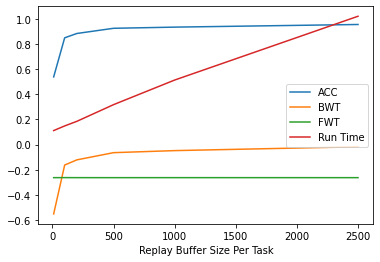

In [35]:
plt.plot(memory_size, accs, label="ACC")
plt.plot(memory_size, bwts, label="BWT")
plt.plot(memory_size, fwts, label="FWT")
plt.plot(memory_size, [t/300 for t in times], label="Run Time")
plt.xlabel('Replay Buffer Size Per Task')
plt.legend()

در نمودار نیز مشاهده می شود که استفاده از حافظه انتقال رو به عقب را کنترل می کند و دقت نهایی روی تسک ها را افزایش داده و از فراموشی جلوگیری می کند.

همچنین با توجه به شیب نمودار ها نکته جالب کافی بودن ذخیره تعداد کمی داده برای هر تسک است و می بینیم که بیشتر کردن سایز مموری زیاد با توجه به افزایش زمان آموزش تاثیر گذاری خاصی ندارد و همان اطراف ۳۰۰ داده در ۳۰۰۰ داده برای ذخیره کافی است